# Day049-050 期末主題 - 浣熊與袋鼠辨識模型

## 專案目標：

建立一個模型同時能辨識出浣熊(raccoon)與袋鼠(kangaroo)的類別與位置。

參考 train.py 實現的訓練模型程式碼範例

# 查看 GPU 資訊

In [1]:
!nvidia-smi

Wed Mar 18 03:32:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#看到虛擬機有多少 RAM

In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]

def printGPU():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  
printGPU()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=a6c9b1ba745cf4d8bac899b9cb07f9dd7429539b2139b8e361e73d556ff0a50c
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 157.3 MB
GPU RAM Free: 7611MB | Used: 0MB | Util   0% | Total 7611MB


## GPU設定 

In [3]:
#載入套件
import os
import tensorflow as tf
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = " 0 "
# 只使用 50% 的 GPU 記憶體
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
#session = tf.Session(config=config)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
#確認tensorflow的版本
print("tensorflow的版本: ",tf.__version__) 
#%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2

tensorflow的版本:  1.15.0


## 確認GPU運行

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 36.2MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [6]:
 from google.colab import drive
drive.mount('/content/gdrive')
# 指定google drive雲端硬碟的跟目錄，名為drive
!mkdir -p gdrive
!google-drive-ocamlfuse drive
import os
# 此處為google drive中的文件路徑，drive為之前指定的工作跟目錄，要加上位置
# 如果存放的路徑有變，從/content/drive/My Drive/XXXXX...做調整
path = "/content/gdrive/My Drive/深度學習與電腦視覺學習馬拉松/Day_49-50/Day049-050"
os.chdir(path)

!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/bin/bash: google-drive-ocamlfuse: command not found
coco_annotation.py	  kangaroo_train.txt  test_data.txt
convert.py		  kmeans.py	      train_bottleneck.py
darknet53.cfg		  LICENSE	      train_data.txt
data			  logs		      train.py
Day049-050_FinalHW	  model_data	      voc_annotation.py
Day049-050_FinalHW.ipynb  __pycache__	      yolo3
font			  raccoon_list.txt    yolo.py
gdrive			  Raccoon.mp4	      yolov3.cfg
kangaroo_list.txt	  raccoon_test.txt    yolov3

In [7]:
#載入套件
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [8]:
# 讀取raccoon_data/images資料夾，建立image list
import glob
def prepare_image_list(image_path, list_file):
    image_list = glob.glob(image_path + '*.jpg') # 讀取所有文件
    with open(list_file,'w',encoding='UTF-8') as f:
        for item in image_list:
            f.write("%s\n" % item)
    return image_list

raccoon_image_path = 'data/raccoon_dataset-master/images/'
raccoon_list = prepare_image_list(raccoon_image_path, 'raccoon_list.txt')

kangaroo_image_path = "data/kangaroo-master/images/"
kangaroo_list = prepare_image_list(kangaroo_image_path, 'kangaroo_list.txt')

print("raccoon_list: ",raccoon_list)
print()# 換行
print("kangaroo_list: ",kangaroo_list)

raccoon_list:  ['data/raccoon_dataset-master/images/raccoon-106.jpg', 'data/raccoon_dataset-master/images/raccoon-104.jpg', 'data/raccoon_dataset-master/images/raccoon-107.jpg', 'data/raccoon_dataset-master/images/raccoon-105.jpg', 'data/raccoon_dataset-master/images/raccoon-103.jpg', 'data/raccoon_dataset-master/images/raccoon-1.jpg', 'data/raccoon_dataset-master/images/raccoon-10.jpg', 'data/raccoon_dataset-master/images/raccoon-100.jpg', 'data/raccoon_dataset-master/images/raccoon-101.jpg', 'data/raccoon_dataset-master/images/raccoon-102.jpg', 'data/raccoon_dataset-master/images/raccoon-114.jpg', 'data/raccoon_dataset-master/images/raccoon-108.jpg', 'data/raccoon_dataset-master/images/raccoon-109.jpg', 'data/raccoon_dataset-master/images/raccoon-110.jpg', 'data/raccoon_dataset-master/images/raccoon-11.jpg', 'data/raccoon_dataset-master/images/raccoon-111.jpg', 'data/raccoon_dataset-master/images/raccoon-112.jpg', 'data/raccoon_dataset-master/images/raccoon-115.jpg', 'data/raccoon_da

訓練時的驗證資料在訓練時的前處理會再分開，所以目前僅將影像僅區分為訓練 (raccoon_train、kangaroo_train) 和測試 (raccoon_test、kangaroo_test)，清單中為image路徑，也和原課程範例不一樣

In [9]:
# 載入套件
import numpy as np
categories = ['raccoon', 'kangaroo']
def prepare_train_test(categories, ratio):
    for category in categories:
        train_list, test_list = read_class_list(category, ratio)
        with open(category+'_train.txt', 'w') as f:
            for item in train_list:
                f.write("%s\n" % item)
        
        with open(category+'_test.txt', 'w') as f:
            for item in test_list:
                f.write("%s\n" % item)
    


def read_class_list(category, ratio):
    list_file = category + '_list.txt'
    with open(list_file) as f:
        image_list = [line.rstrip('\n') for line in f]
    np.random.seed(10000)
    np.random.shuffle(image_list)
    np.random.seed(None)
    num_list = len(image_list)
    num_test = int(num_list*ratio)
    print('getting {} test data and {} train data from {} list ({})'.format(num_test, num_list-num_test, category, num_list))
    test = image_list[:num_test]
    train = image_list[num_test:]
    return train, test

test_ratio = 0.1
prepare_train_test(categories, 0.1)

getting 20 test data and 180 train data from raccoon list (200)
getting 16 test data and 148 train data from kangaroo list (164)


In [10]:
# test if the list file is ok
with open('raccoon_train.txt') as f:
    image_list = [line.rstrip('\n') for line in f]
    print(image_list)
with open('kangaroo_test.txt') as f:
    image_list = [line.rstrip('\n') for line in f]
    print(image_list)

['data/raccoon_dataset-master/images/raccoon-9.jpg', 'data/raccoon_dataset-master/images/raccoon-40.jpg', 'data/raccoon_dataset-master/images/raccoon-67.jpg', 'data/raccoon_dataset-master/images/raccoon-63.jpg', 'data/raccoon_dataset-master/images/raccoon-117.jpg', 'data/raccoon_dataset-master/images/raccoon-54.jpg', 'data/raccoon_dataset-master/images/raccoon-172.jpg', 'data/raccoon_dataset-master/images/raccoon-12.jpg', 'data/raccoon_dataset-master/images/raccoon-23.jpg', 'data/raccoon_dataset-master/images/raccoon-128.jpg', 'data/raccoon_dataset-master/images/raccoon-95.jpg', 'data/raccoon_dataset-master/images/raccoon-157.jpg', 'data/raccoon_dataset-master/images/raccoon-193.jpg', 'data/raccoon_dataset-master/images/raccoon-102.jpg', 'data/raccoon_dataset-master/images/raccoon-61.jpg', 'data/raccoon_dataset-master/images/raccoon-79.jpg', 'data/raccoon_dataset-master/images/raccoon-99.jpg', 'data/raccoon_dataset-master/images/raccoon-180.jpg', 'data/raccoon_dataset-master/images/rac

In [11]:
import os
if not os.path.exists("train_data.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd
    from os import path

    annots = {'raccoon':'data/raccoon_dataset-master/annotations/',
              'kangaroo': 'data/kangaroo-master/annots/'}
    sets=['train', 'test']

    # 專題的辨識目標 
    categories = ['raccoon', 'kangaroo']

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(annot_path, image_id, list_file):
        image_id = path.splitext(path.basename(image_file))[0]
        in_file = open('%s%s.xml' % (annot_path, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in categories or int(difficult)==1:
                continue
            cls_id = categories.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

        wd = "."

    for image_set in sets:
        annotation_path = '%s_data.txt'%(image_set)
        with open(annotation_path, 'a') as list_file:
            print("save annotation at %s" % annotation_path)
            for category in categories:
                image_files = open('%s_%s.txt'%(category, image_set)).read().strip().split()
                for image_file in image_files:
                    list_file.write(image_file)
                    convert_annotation(annots[category], image_file, list_file)
                    list_file.write('\n')
else:
    print('annotation data is existed!!')

annotation data is existed!!


# 訓練模型

In [12]:
# 將 train.py 所需要的套件載入
# 載入套件
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [0]:
# 載入套件
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 -w 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [14]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [0]:
# predefined parameters
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
CUDA_VISIBLE_DEVICES = 0

annotation_path = 'train_data.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.3
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 2
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=600,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 2 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=300,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')












Create YOLOv3 model with 9 anchors and 20 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 75) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 75) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 230 samples, val on 98 samples, with batch size 2.




Epoch 1/600
115/115 [==============================] - 167s 1s/step - loss: 786.1388 - val_loss: 98.3111

Epoch 2/600
115/115 [==============================] - 23s 198ms/step - loss: 74.2263 - val_loss: 53.1081
Epoch 3/600
115/115 [==============================] - 23s 200ms/step - loss: 46.9184 - val_loss: 38.2942
Epoch 4/600
115/115 [==============================] - 23s 197ms/step - loss: 36.7356 - val_loss: 31.6296
Epoch 5/600
115/115 [==============================] - 23s 201ms/step - loss: 30.3281 - val_loss: 28.7508
Epoch 6/600
115/115 [==============================] - 23s 201ms/step - loss: 27.2225 - val_loss: 27.3521
Epoch 7/600
115/115 [==============================] - 24s 206ms/step - loss: 25.3135 - val_loss: 24.6875
Epoch 8/

In [0]:
input_shape = (416,416) # multiple of 32, hw
weights_path=log_dir + 'trained_weights_stage_1.h5'
model = create_model(input_shape, anchors, num_classes, weights_path=weights_path)

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    weights_path=log_dir + 'trained_tiny_weights_stage_1.h5'
    model = create_tiny_model(input_shape, anchors, num_classes,weights_path=weights_path)
else:
    weights_path=log_dir + 'trained_weights_stage_1.h5'
    model = create_model(input_shape, anchors, num_classes, weights_path=weights_path)

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 2 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 20 classes.
Load weights logs/000/trained_weights_stage_1.h5.
Freeze the first 249 layers of total 252 layers.
Create YOLOv3 model with 9 anchors and 20 classes.
Load weights logs/000/trained_weights_stage_1.h5.
Freeze the first 249 layers of total 252 layers.
Unfreeze all of the layers.
Train on 296 samples, val on 32 samples, with batch size 2.
Epoch 51/100
148/148 [==============================] - 39s 262ms/step - loss: 18.7167 - val_loss: 17.8920
Epoch 52/100
148/148 [==============================] - 29s 198ms/step - loss: 17.0411 - val_loss: 16.9866
Epoch 53/100
148/148 [==============================] - 31s 207ms/step - loss: 16.3451 - val_loss: 15.6353
Epoch 54/100
148/148 [==============================] - 29s 198ms/step - loss: 16.1341 - val_loss: 16.1961
Epoch 55/100
148/148 [==============================] - 30s 201ms/step - loss: 15.9586 - val_loss: 15.6450
Epoch 56/100
148/148 [==============================] - 31s 206ms/step - loss

# 運用模型，辨識驗證資料集 (test data) 的效果，並透過指標判斷模型的優劣

In [0]:
import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model
# 定義 YOLO class
class YOLO(object):
    _defaults = {
        "model_path": 'model_data/yolo.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/coco_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    # 更改 detect_image 使得其回傳需要的信息
    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        # return image # Hint: 在這裡更改程式碼即可
        return out_boxes, out_scores, out_classes, image

    def close_session(self):
        self.sess.close()

測試影像來測試是否YOLO可正常偵測











logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(416, 416, 3)
Found 1 boxes for img
aeroplane 0.99 (571, 0) (946, 564)
8.176062907000016


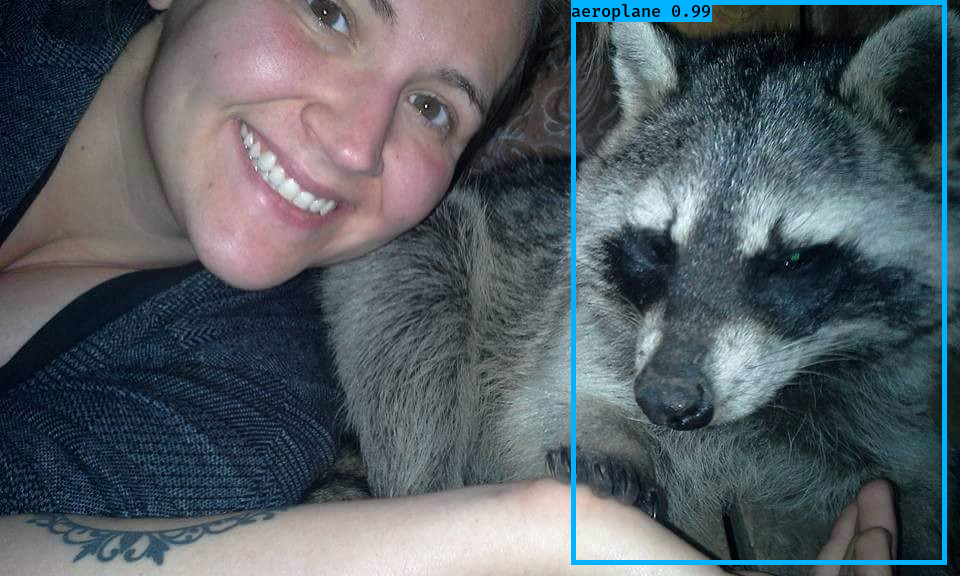

In [20]:
annotation_path = 'train_data.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

from PIL import Image
image = Image.open('data/raccoon_dataset-master/images/raccoon-100.jpg')
# from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
out_boxes, out_scores, out_classes, r_image = yolo_model.detect_image(image)
r_image

In [21]:
print(out_boxes, out_scores, out_classes)

[[-21.051796 571.1713   563.907    946.0785  ]] [0.98826265] [0]


# 找出影片中的袋鼠與浣熊

In [0]:
# 載入套件
from yolo import YOLO
import  yolo

annotation_path = 'train_data.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_paths = 'model_data/voc_classes.txt'
anchors_paths = 'model_data/yolo_anchors.txt'
video_input='Kangaroo.mp4'
video_output='Kangaroo-YOLOV3.mp4'

In [23]:
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_paths)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


In [0]:
yolo.detect_video(yolo_model, video_path=video_input,output_path=video_output)

!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>
(416, 416, 3)
Found 2 boxes for img
bicycle 0.59 (0, 0) (514, 720)
aeroplane 0.68 (36, 0) (1232, 720)
1.5538332229999696


## 參考資料(Reference) 

Day41_train_yolov3_Sample